# [Refine Use of Explored NTD Variables #1646](https://github.com/cal-itp/data-analyses/issues/1646)

Question or Goal:

1. **COMPLETE** Mode & Service: We previously used these to define the grain of the data. These should be used for classifying/model-fitting.
    - There are many modes: Can we group modes so there are fewer of them (e.g. fixed-guideway vs not)? Too many dummy variables for a category leads to overfitting/too many clusters.
    - What's the best way to use Service? Is it as a dummy variable? Is it numeric "proportion of service(VRH or M)" that's directly operated? Explore the impacts of both.

2. ~~If we group by only Agency (flattening, fewer rows), how do we aggregate the other classification variables before we normalize them? Is adding sufficient? Do we need to average any?~~
    - Work continuing on isue #1683

3. Are there ways to get more interactive/easy-to-read visualizations?
    - If it takes significant time, break this one out

## Terms
**Example**:
- You could think of an example as analogous to a `single row` in a spreadsheet.

**Feature**:
- Features are the values that a supervised model uses to predict the label.
- In a weather model that predicts rainfall, the features could be `latitude, longitude, temperature, humidity, cloud coverage, wind direction, and atmospheric pressure`.
- An input variable to a machine learning model. An example consists of one or more features. For instance, suppose you are training a model to determine the influence of weather conditions on student test scores. The following table shows three examples, each of which contains three features and one label:

**Label**:
- The label is the "answer," or the value we want the model to predict.
- In a weather model that predicts rainfall, the label would be `rainfall amount`.
- In supervised machine learning, the "answer" or "result" portion of an example. Each labeled example consists of one or more features and a label. For example, in a spam detection dataset, the label would probably be either "spam" or "not spam." In a rainfall dataset, the label might be the amount of rain that fell during a certain period.

---

# Knowledge Check

In [88]:
import sys
import altair as alt
import pandas as pd

sys.path.append("../ntd/monthly_ridership_report")
from update_vars import GCS_FILE_PATH, NTD_MODES, NTD_TOS

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## Test querying NTD data from warehouse
I queried data from `mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_{metric}`


In [2]:
from calitp_data_analysis.sql import get_engine

In [18]:
db_engine = get_engine()

with db_engine.connect() as connection:
    # including mode and service will make the table bigger, and would need another aggregation to get yearly totals
    query = f"""
        SELECT
          upt.ntd_id,
          upt.source_agency,
          upt.agency_status,
          upt.city,
          upt.primary_uza_name,
          upt.uza_population,
          upt.uza_area_sq_miles,
          upt.year,
          upt.mode,
          upt.service,
          upt.reporter_type,
          SUM(upt.upt) AS total_upt,
          SUM(voms.voms) AS total_voms,
          SUM(vrh.vrh) AS total_vrh,
          SUM(vrm.vrm) AS total_vrm,
          SUM(opexp_total.opexp_total) AS opexp_total
        FROM
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_upt AS upt
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_voms AS voms
        ON
          upt.ntd_id = voms.ntd_id
          AND upt.year = voms.year
          AND upt.source_agency = voms.source_agency
          AND upt.agency_status = voms.agency_status
          AND upt.primary_uza_name = voms.primary_uza_name
          AND upt.uza_population = voms.uza_population
          AND upt.uza_area_sq_miles = voms.uza_area_sq_miles
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrh AS vrh
        ON
          upt.ntd_id = vrh.ntd_id
          AND upt.year = vrh.year
          AND upt.source_agency = vrh.source_agency
          AND upt.agency_status = vrh.agency_status
          AND upt.primary_uza_name = vrh.primary_uza_name
          AND upt.uza_population = vrh.uza_population
          AND upt.uza_area_sq_miles = vrh.uza_area_sq_miles
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrm AS vrm
        ON
          upt.ntd_id = vrm.ntd_id
          AND upt.year = vrm.year
          AND upt.source_agency = vrm.source_agency
          AND upt.agency_status = vrm.agency_status
          AND upt.primary_uza_name = vrm.primary_uza_name
          AND upt.uza_population = vrm.uza_population
          AND upt.uza_area_sq_miles = vrm.uza_area_sq_miles
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_opexp_total AS opexp_total
        ON
          upt.ntd_id = opexp_total.ntd_id
          AND upt.year = opexp_total.year
          AND upt.source_agency = opexp_total.source_agency
          AND upt.agency_status = opexp_total.agency_status
          AND upt.primary_uza_name = opexp_total.primary_uza_name
          AND upt.uza_population = opexp_total.uza_population
          AND upt.uza_area_sq_miles = opexp_total.uza_area_sq_miles
        WHERE
          upt.source_state = "CA"
          AND upt.year >= 2018
        GROUP BY
          upt.ntd_id,
          upt.source_agency,
          upt.agency_status,
          upt.city,
          upt.year,
          upt.primary_uza_name,
          upt.uza_population,
          upt.uza_area_sq_miles,
          upt.mode,
          upt.service,
          upt.reporter_type
        """
    # create df
    raw_ntd_metrics_merge = pd.read_sql(query, connection)

In [19]:
# reverse_mode = {v: k for k,v in NTD_MODES.items()}
# reverse_tos = {v:k for k,v in NTD_TOS.items()}

replace_dict = {"mode": NTD_MODES, "service": NTD_TOS}

for k, v in replace_dict.items():
    raw_ntd_metrics_merge[k] = raw_ntd_metrics_merge[k].replace(v)
    # test_query[k] = test_query[k].replace(v)

display(
    raw_ntd_metrics_merge["mode"].unique(),
    # test_query["service"].unique(),
    # test_query.equals(raw_ntd_metrics_merge)
)

array(['Bus', 'Demand Response', 'Streetcar', 'Commuter Bus', 'Vanpool',
       'Commuter Rail', 'Demand Response Taxi', 'Heavy Rail',
       'Light Rail', 'Bus Rapid Transit', 'Trolleybus', 'Cable Car',
       'Ferryboats', 'OT', 'Jitney', 'OR',
       'Monorail / Automated Guideway', 'Hybrid Rail'], dtype=object)

## save out to GCS

In [21]:
# raw_ntd_metrics_merge.to_parquet(f"{GCS_FILE_PATH}transit_peer_group_data_18-23.parquet")

## read in GCS data

In [22]:
raw_ntd_metrics_merge = pd.read_parquet(
    f"{GCS_FILE_PATH}transit_peer_group_data_18-23.parquet"
)

In [23]:
# without mode/service - 1524 rows
# with mode/service - 4002
raw_ntd_metrics_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4002 entries, 0 to 4001
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ntd_id             4002 non-null   object 
 1   source_agency      4002 non-null   object 
 2   agency_status      4002 non-null   object 
 3   city               1181 non-null   object 
 4   primary_uza_name   4002 non-null   object 
 5   uza_population     4002 non-null   int64  
 6   uza_area_sq_miles  4002 non-null   float64
 7   year               4002 non-null   int64  
 8   mode               4002 non-null   object 
 9   service            4002 non-null   object 
 10  reporter_type      4002 non-null   object 
 11  total_upt          2623 non-null   float64
 12  total_voms         3600 non-null   float64
 13  total_vrh          3600 non-null   float64
 14  total_vrm          3600 non-null   float64
 15  opexp_total        3600 non-null   float64
dtypes: float64(6), int64(2),

In [25]:
# aggregating to get yearly totals, but missing mode/service
ntd_metrics_yearly = (
    raw_ntd_metrics_merge.groupby(
        [
            "ntd_id",
            "source_agency",
            "agency_status",
            "reporter_type",
            "primary_uza_name",
            "uza_population",
            "uza_area_sq_miles",
            "year",
        ]
    )
    .agg(sum)
    .reset_index()
)

# each row is an agencies total for the year, for 6 years (2018-2023). each agency should have 6 rows.
ntd_metrics_yearly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1524 entries, 0 to 1523
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ntd_id             1524 non-null   object 
 1   source_agency      1524 non-null   object 
 2   agency_status      1524 non-null   object 
 3   reporter_type      1524 non-null   object 
 4   primary_uza_name   1524 non-null   object 
 5   uza_population     1524 non-null   int64  
 6   uza_area_sq_miles  1524 non-null   float64
 7   year               1524 non-null   int64  
 8   total_upt          1524 non-null   float64
 9   total_voms         1524 non-null   float64
 10  total_vrh          1524 non-null   float64
 11  total_vrm          1524 non-null   float64
 12  opexp_total        1524 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 154.9+ KB


/tmp/ipykernel_1632/2661189013.py:16: FutureWarning: The operation <built-in function sum> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  .agg(sum)


## Check correlation matrix

In [26]:
corr_matrix = (
    ntd_metrics_yearly[
        [
            "opexp_total",
            "total_upt",
            "total_vrh",
            "total_vrm",
            "total_voms",
            "uza_area_sq_miles",
            "uza_population",
        ]
    ]
    .corr()
    .round(4)
)

corr_matrix

,opexp_total,total_upt,total_vrh,total_vrm,total_voms,uza_area_sq_miles,uza_population
opexp_total,1.0000,0.9541,0.9521,0.9288,0.8716,0.1073,0.0878
total_upt,0.9541,1.0000,0.9065,0.8861,0.8294,0.1050,0.0900
total_vrh,0.9521,0.9065,1.0000,0.9943,0.9746,0.1165,0.0966
total_vrm,0.9288,0.8861,0.9943,1.0000,0.9848,0.1170,0.0982
total_voms,0.8716,0.8294,0.9746,0.9848,1.0000,0.1158,0.1001
uza_area_sq_miles,0.1073,0.1050,0.1165,0.1170,0.1158,1.0000,0.9222
uza_population,0.0878,0.0900,0.0966,0.0982,0.1001,0.9222,1.0000


In [97]:
corr_melt = corr_matrix.reset_index().melt(id_vars="index")

In [98]:
alt.Chart(corr_melt).mark_rect().encode(
    x="index",
    y="variable",
    color="value"
)

alt.Chart(...)

There are way more pairwise variables over 0.9.
List of pairwise variables under 0.9
- opex & voms: 0.87
- opex & uza area: 0.11
- opex & uza pop: 0.09
- upt & vrm: 0.88
- upt & voms: 0.82
- upt & uza area: 0.11 
- upt & uza pop: 0.09
- vrh & uza area: 0.12
- vrh & uza pop: 0.09
- vrm & uza area: 0.12
- vrm & uza pop: 0.10
- voms & uza area : 0.12
- voms & uza pop: 0.10



## Classify feature columns

In [27]:
list(raw_ntd_metrics_merge.columns)

['ntd_id',
 'source_agency',
 'agency_status',
 'city',
 'primary_uza_name',
 'uza_population',
 'uza_area_sq_miles',
 'year',
 'mode',
 'service',
 'reporter_type',
 'total_upt',
 'total_voms',
 'total_vrh',
 'total_vrm',
 'opexp_total']

In [78]:
# Feature groups

# exclude from clustering
id_cols = [
    "source_agency",
    "city",
    "ntd_id",
    "primary_uza_name",
    # "reporter_type",  # maybe move to categorical
]

# include in clustering
categorical_cols = ["mode", "service", "reporter_type"]

# include in clustering
numerical_cols = [
    "total_upt",
    "total_vrh",
    "total_vrm",
    "opexp_total",
    "total_voms",
    # "uza_population",
    # "uza_area_sq_miles",
]

# exclude in clustering
other_cols = [
    "agency_status",
    "year",
    "reporting_module",
    "_merge",
]

## 2. Mode & Service

### Unique `Mode` sub-categories
Previous research papers categorized mode by have/not have "dedicated right of way"/ "fixed guideway".

In [52]:
list(raw_ntd_metrics_merge["mode"].unique())


['Bus',
 'Demand Response',
 'Streetcar',
 'Commuter Bus',
 'Vanpool',
 'Commuter Rail',
 'Demand Response Taxi',
 'Heavy Rail',
 'Light Rail',
 'Bus Rapid Transit',
 'Trolleybus',
 'Cable Car',
 'Ferryboats',
 'OT',
 'Jitney',
 'OR',
 'Monorail / Automated Guideway',
 'Hybrid Rail']

In [48]:
# what is `OT` and `OR`?

# Which agencies have mode OT/OTR?!
raw_ntd_metrics_merge[raw_ntd_metrics_merge["mode"].isin(["OT", "OR"])][
    "source_agency"
].unique()

array(['City of Dinuba', 'City of Rio Vista - Department of Public Works',
       'City of Tracy - Transit Division',
       'County of Glenn - Glenn County Planning and Community Development Services Agency',
       'Lassen Transit Service Agency (LTSA)',
       'San Benito County Local Transportation Authority (\t\t)',
       'Susanville Indian Rancheria(SIR)', 'Tehama County (TRAX)'],
      dtype=object)

In [49]:
fixed_guideway = [
    "Streetcar",
    "Heavy Rail",
    "Hybrid Rail",
    "Commuter Rail",
    "Cablecar",
    "Light Rail",
    "Monorail / Automated Guideway",
]

other = [
    "Trolleybus", 
    "Ferryboats", 
    "OT", 
    "OR"
]

nonfixed_guideway = [
    "Demand Response",
    "Bus",
    "Demand Response Taxi",
    "Commuter Bus",
    "Vanpool",
    "Bus Rapid Transit",
]

### testing what the dataframe will look like if you separate fixed from nonfixed guideway

In [40]:
fixed_guideway_df = raw_ntd_metrics_merge[
    raw_ntd_metrics_merge["mode"].isin(fixed_guideway)
]

nonfixed_guideway_df = raw_ntd_metrics_merge[
    raw_ntd_metrics_merge["mode"].isin(nonfixed_guideway)
]

In [50]:
display(
    fixed_guideway_df.shape,
    fixed_guideway_df["mode"].unique(),
)

(156, 16)

array(['Streetcar', 'Commuter Rail', 'Heavy Rail', 'Light Rail',
       'Monorail / Automated Guideway', 'Hybrid Rail'], dtype=object)

In [51]:
display(
    nonfixed_guideway_df.shape,
    nonfixed_guideway_df["mode"].unique(),
)

(3732, 16)

array(['Bus', 'Demand Response', 'Commuter Bus', 'Vanpool',
       'Demand Response Taxi', 'Bus Rapid Transit'], dtype=object)

### Unique `Service` values

In [53]:
list(raw_ntd_metrics_merge["service"].unique())

['Purchased Transportation',
 'Directly Operated',
 'Purchased Transportation - Taxi',
 'Purchased Transportation - Transportation Network Company']

In [61]:
service_pt_do = [
    "Purchased Transportation",
    "Directly Operated",
]

service_other = [
    "Purchased Transportation - Taxi",
    "Purchased Transportation - Transportation Network Company",
]

In [58]:
display(
    fixed_guideway_df["service"].value_counts(),
    nonfixed_guideway_df["service"].value_counts(),
    nonfixed_guideway_df[nonfixed_guideway_df["service"].str.contains("- T")]["source_agency"].value_counts()
)

Directly Operated           102
Purchased Transportation     54
Name: service, dtype: int64

Purchased Transportation                                     2364
Directly Operated                                            1200
Purchased Transportation - Taxi                               138
Purchased Transportation - Transportation Network Company      30
Name: service, dtype: int64

City of Carson - Transportation Services Division                                 12
Sacramento Regional Transit District                                              12
Orange County Transportation Authority (OCTA)                                      6
City of Torrance (TTS) - Transit Department                                        6
The Eastern Contra Costa Transit Authority                                         6
San Mateo County Transit District (SMCTD)                                          6
San Joaquin Regional Transit District (RTD)                                        6
San Diego Metropolitan Transit System (MTS)                                        6
Riverside Transit Agency (RTA)                                                     6
Pomona Valley Transportation Authority (PVTA)                                      6
Paratransit, Inc.                                                                  6
Palos Verdes Peninsula Transit Authority (PVPTA)                 

**RE: what to do with service columns**

- The majority of rows are either Purchased Transportation or Directly Operated. close to a binary response so i think one-hot encode would be the best option.
- Maybe consider removing the PT taxi and PT transportation netwok since there is a low count of rows

## 3. "Flattening" data
If we group by only Agency (flattening, fewer rows), how do we aggregate the other classification variables before we normalize them? Is adding sufficient? Do we need to average any?

If we aggregate to get 1 row per agency, what happens to the other categorical variables?

In [74]:
numerical_cols

['total_upt',
 'total_vrh',
 'total_vrm',
 'opexp_total',
 'total_voms',
 'uza_population',
 'uza_area_sq_miles']

In [79]:
# agg the numerical row, end with each row being an agency
group_id_cols = (
    raw_ntd_metrics_merge.groupby(id_cols)
    .agg({col: "sum" for col in numerical_cols})
    .reset_index()
)

# agg the numerical row, end with each row being a uniqu agency/mode/service
group_id_mode_service = (
    raw_ntd_metrics_merge.groupby(id_cols + ["mode", "service"])
    .agg({col: "sum" for col in numerical_cols})
    .reset_index()
)

# agg the numerical row, end with each row being an agency
group_cat_cols = (
    raw_ntd_metrics_merge.groupby(categorical_cols)
    .agg({col: "sum" for col in numerical_cols})
    .reset_index()
)

In [64]:
# double checking aggregation works
(
    raw_ntd_metrics_merge[raw_ntd_metrics_merge["ntd_id"] == "90211"][
        "opexp_total"
    ].sum()
    == group_id_cols[group_id_cols["ntd_id"] == "90211"]["opexp_total"].sum(),
    raw_ntd_metrics_merge[raw_ntd_metrics_merge["mode"] == "Bus"]["opexp_total"].sum()
    == group_cat_cols[group_cat_cols["mode"] == "Bus"]["opexp_total"].sum(),
)

(False, True)

In [65]:
display(
    "group_id",
    group_id_cols.shape,
    # group_id_cols["service"].value_counts(),
    group_id_cols.head(),
    "group_id_mode_service",
    group_id_mode_service.shape,
    group_id_mode_service["service"].value_counts(),
    group_id_mode_service.head(),
)

'group_id'

(216, 11)

,source_agency,city,ntd_id,primary_uza_name,total_upt,total_vrh,total_vrm,opexp_total,total_voms,uza_population,uza_area_sq_miles
0,Access Services (AS),El Monte,90157,"Los Angeles--Long Beach--Anaheim, CA",5.243015e+08,2.838753e+08,4.863772e+09,3.009580e+10,132759.0,73424256,9820.98
1,Alameda-Contra Costa Transit District,Oakland,90014,"San Francisco--Oakland, CA",8.364078e+10,5.104948e+09,5.547737e+10,1.283436e+12,1511136.0,42191196,6165.60
2,Altamont Corridor Express (ACE),Stockton,90182,"Stockton, CA",1.274000e+07,7.488480e+05,2.970434e+07,9.888552e+08,864.0,1659388,369.84
3,Amador Transit (AT),Jackson,91000,California Non-UZA,4.655799e+06,2.009367e+06,3.950969e+07,2.333560e+08,2835.0,26147100,0.00
4,Anaheim Transportation Network (ATN),Anaheim,90211,"Los Angeles--Long Beach--Anaheim, CA",2.476313e+08,4.909824e+06,3.577339e+07,5.100877e+08,1616.0,48949504,6547.32


'group_id_mode_service'

(600, 13)

Purchased Transportation                                     366
Directly Operated                                            206
Purchased Transportation - Taxi                               23
Purchased Transportation - Transportation Network Company      5
Name: service, dtype: int64

,source_agency,city,ntd_id,primary_uza_name,mode,service,total_upt,total_vrh,total_vrm,opexp_total,total_voms,uza_population,uza_area_sq_miles
0,Access Services (AS),El Monte,90157,"Los Angeles--Long Beach--Anaheim, CA",Demand Response,Purchased Transportation,3.764843e+08,94625091.0,1.621257e+09,1.003193e+10,44253.0,24474752,3273.66
1,Access Services (AS),El Monte,90157,"Los Angeles--Long Beach--Anaheim, CA",Demand Response,Purchased Transportation - Taxi,1.478172e+08,94625091.0,1.621257e+09,1.003193e+10,44253.0,24474752,3273.66
2,Access Services (AS),El Monte,90157,"Los Angeles--Long Beach--Anaheim, CA",Demand Response Taxi,Purchased Transportation,0.000000e+00,94625091.0,1.621257e+09,1.003193e+10,44253.0,24474752,3273.66
3,Alameda-Contra Costa Transit District,Oakland,90014,"San Francisco--Oakland, CA",Bus,Directly Operated,7.146366e+10,850824648.0,9.246228e+09,2.139059e+11,251856.0,7031866,1027.60
4,Alameda-Contra Costa Transit District,Oakland,90014,"San Francisco--Oakland, CA",Bus,Purchased Transportation,3.746036e+08,850824648.0,9.246228e+09,2.139059e+11,251856.0,7031866,1027.60


In [66]:
display("group_cat", group_cat_cols.shape, group_cat_cols.head())

'group_cat'

(58, 10)

,mode,service,reporter_type,total_upt,total_vrh,total_vrm,opexp_total,total_voms,uza_population,uza_area_sq_miles
0,Bus,Directly Operated,Full Reporter,9.852488e+12,7.331355e+10,9.655963e+11,1.435647e+13,28553743.0,1240088322,180231.30
1,Bus,Directly Operated,Reduced Reporter,7.707831e+08,6.916987e+07,8.659638e+08,7.962925e+09,42485.0,455909166,46814.16
2,Bus,Directly Operated,Rural Reporter,1.625084e+09,1.350624e+08,2.428739e+09,1.331917e+10,104968.0,758265900,0.00
3,Bus,Directly Operated,Separate Service,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,11679708,2805.48
4,Bus,Purchased Transportation,Building Reporter,3.420411e+07,1.801776e+06,2.348028e+07,1.584634e+08,512.0,419172,98.10


### **This establishes we can aggregate up to just agecny level data.**

but still need to consider what to do with the categorical columns we lose from a simple aggregate.

this work will continue on issue #1683

# Are there ways to get more interactive/easy-to-read visualizations?
If it takes significant time, break this one out

Might have to break this out. What other visuals would make sense for hierarchal clustering?
- dendrogram (1 for fixed and non-fixed guideway modes)
- loss curve?
- 


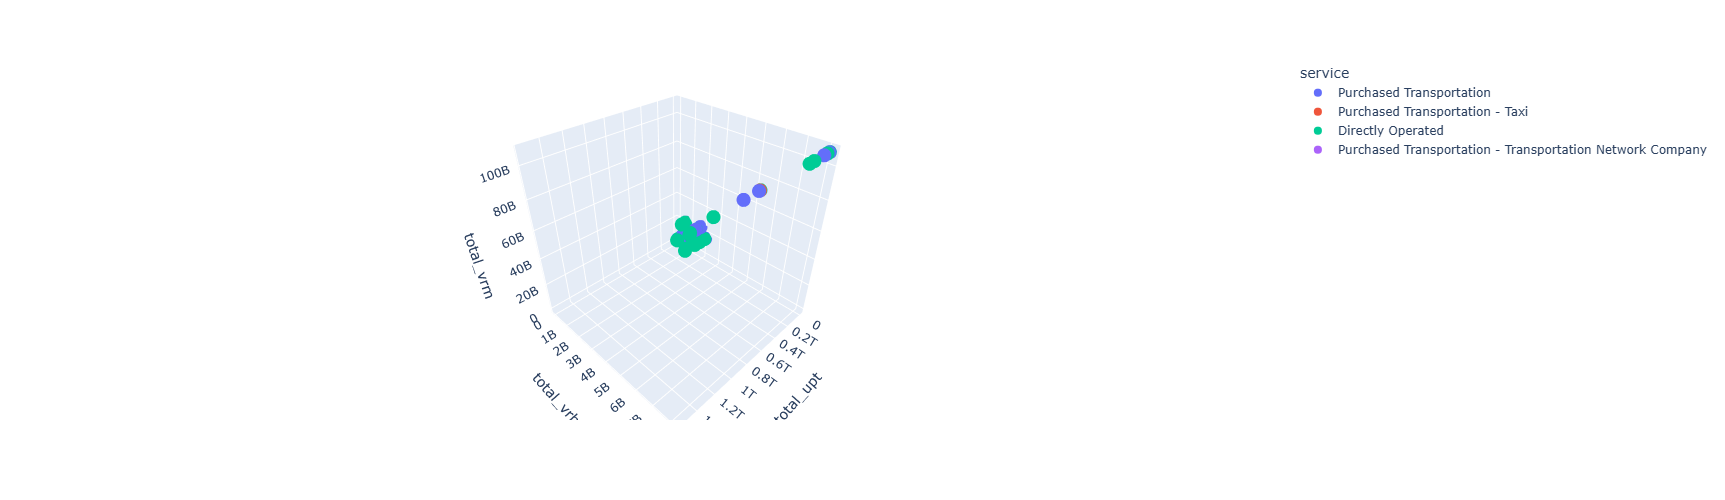

In [105]:
import plotly.express as px

# @title Plot three features in 3D by entering their names and running this cell

x_axis_data = "total_upt"
y_axis_data = "total_vrh"
z_axis_data = "total_vrm"

px.scatter_3d(
    group_id_mode_service,
    x=x_axis_data,
    y=y_axis_data,
    z=z_axis_data,
    color="service",
    width=800,
    height=500,
).show()

## what does 1 year of data look like 

Try with only 2023 data

In [122]:
# alt method to query warehous data, via cal-itp docs

from calitp_data_analysis.sql import query_sql

query = f"""
        SELECT
          upt.ntd_id,
          upt.source_agency,
          upt.agency_status,
          upt.city,
          upt.primary_uza_name,
          upt.uza_population,
          upt.uza_area_sq_miles,
          upt.year,
          upt.mode,
          upt.service,
          upt.reporter_type,
          SUM(upt.upt) AS total_upt,
          SUM(voms.voms) AS total_voms,
          SUM(vrh.vrh) AS total_vrh,
          SUM(vrm.vrm) AS total_vrm,
          SUM(opexp_total.opexp_total) AS opexp_total
        FROM
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_upt AS upt
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_voms AS voms
        ON
          upt.ntd_id = voms.ntd_id
          AND upt.year = voms.year
          AND upt.source_agency = voms.source_agency
          AND upt.agency_status = voms.agency_status
          AND upt.primary_uza_name = voms.primary_uza_name
          AND upt.uza_population = voms.uza_population
          AND upt.uza_area_sq_miles = voms.uza_area_sq_miles
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrh AS vrh
        ON
          upt.ntd_id = vrh.ntd_id
          AND upt.year = vrh.year
          AND upt.source_agency = vrh.source_agency
          AND upt.agency_status = vrh.agency_status
          AND upt.primary_uza_name = vrh.primary_uza_name
          AND upt.uza_population = vrh.uza_population
          AND upt.uza_area_sq_miles = vrh.uza_area_sq_miles
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_vrm AS vrm
        ON
          upt.ntd_id = vrm.ntd_id
          AND upt.year = vrm.year
          AND upt.source_agency = vrm.source_agency
          AND upt.agency_status = vrm.agency_status
          AND upt.primary_uza_name = vrm.primary_uza_name
          AND upt.uza_population = vrm.uza_population
          AND upt.uza_area_sq_miles = vrm.uza_area_sq_miles
        INNER JOIN
          cal-itp-data-infra.mart_ntd_funding_and_expenses.fct_service_data_and_operating_expenses_time_series_by_mode_opexp_total AS opexp_total
        ON
          upt.ntd_id = opexp_total.ntd_id
          AND upt.year = opexp_total.year
          AND upt.source_agency = opexp_total.source_agency
          AND upt.agency_status = opexp_total.agency_status
          AND upt.primary_uza_name = opexp_total.primary_uza_name
          AND upt.uza_population = opexp_total.uza_population
          AND upt.uza_area_sq_miles = opexp_total.uza_area_sq_miles
        WHERE
          upt.source_state = "CA"
          AND upt.year = 2023
        GROUP BY
          upt.ntd_id,
          upt.source_agency,
          upt.agency_status,
          upt.city,
          upt.year,
          upt.primary_uza_name,
          upt.uza_population,
          upt.uza_area_sq_miles,
          upt.mode,
          upt.service,
          upt.reporter_type
        """

ntd_2023_data = query_sql(query).fillna(0)

In [125]:

ntd_2023_data[numerical_cols] = ntd_2023_data[numerical_cols].astype("int64", errors="ignore")
ntd_2023_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667 entries, 0 to 666
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ntd_id             667 non-null    object 
 1   source_agency      667 non-null    object 
 2   agency_status      667 non-null    object 
 3   city               667 non-null    object 
 4   primary_uza_name   667 non-null    object 
 5   uza_population     667 non-null    int64  
 6   uza_area_sq_miles  667 non-null    float64
 7   year               667 non-null    int64  
 8   mode               667 non-null    object 
 9   service            667 non-null    object 
 10  reporter_type      667 non-null    object 
 11  total_upt          667 non-null    int64  
 12  total_voms         667 non-null    int64  
 13  total_vrh          667 non-null    int64  
 14  total_vrm          667 non-null    int64  
 15  opexp_total        667 non-null    int64  
dtypes: float64(1), int64(7), o

In [126]:
ntd_2023_data.head()

,ntd_id,source_agency,agency_status,city,primary_uza_name,uza_population,uza_area_sq_miles,year,mode,service,reporter_type,total_upt,total_voms,total_vrh,total_vrm,opexp_total
0,90198,City of Porterville (COLT) - Transit Department,Active,Porterville,"Porterville, CA",69862,16.35,2023,MB,PT,Building Reporter,0,0,0,0,0
1,90198,City of Porterville (COLT) - Transit Department,Active,Porterville,"Porterville, CA",69862,16.35,2023,DR,PT,Building Reporter,0,0,0,0,0
2,90036,Orange County Transportation Authority (OCTA),Active,Orange,"Los Angeles--Long Beach--Anaheim, CA",12237376,1636.83,2023,SR,PT,Full Reporter,0,1075448,2764357893,37310649233,428923289696
3,90013,Santa Clara Valley Transportation Authority (VTA),Active,San Jose,"San Jose, CA",1837446,285.48,2023,HR,DO,Full Reporter,0,262144,887382528,11150999040,232484337152
4,90170,ATC / Vancom,Inactive,0,"San Francisco--Oakland, CA",3515933,513.80,2023,DR,PT,Full Reporter,0,0,0,0,0


In [128]:
ntd_2023_data[numerical_cols].corr()

,total_upt,total_vrh,total_vrm,opexp_total,total_voms
total_upt,1.000000,0.447327,0.438990,0.467137,0.428977
total_vrh,0.447327,1.000000,0.993603,0.970093,0.992880
total_vrm,0.438990,0.993603,1.000000,0.958037,0.991704
opexp_total,0.467137,0.970093,0.958037,1.000000,0.939107
total_voms,0.428977,0.992880,0.991704,0.939107,1.000000


In [129]:
ntd_2023_data["service"].value_counts()

PT    409
DO    230
TX     23
TN      5
Name: service, dtype: int64

In [130]:
ntd_2023_data["mode"].value_counts()

DR    263
MB    244
CB     51
DT     39
VP     21
LR      8
CR      8
FB      7
OT      7
RB      4
YR      3
HR      3
OR      2
MG      2
SR      2
JT      1
CC      1
TB      1
Name: mode, dtype: int64

In [131]:
from sklearn.cluster import AgglomerativeClustering 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [132]:
numerical_cols

['total_upt', 'total_vrh', 'total_vrm', 'opexp_total', 'total_voms']

In [133]:
categorical_cols

['mode', 'service', 'reporter_type']

In [140]:
# 1. set up pre-processing with column transformer

preprocessor = ColumnTransformer(
    [
        ("numeric", StandardScaler, numerical_cols),
        ("categorical", OneHotEncoder(drop="first", sparse_output=False), categorical_cols)
    ]
)
preprocessor

TypeError: _HTMLDocumentationLinkMixin._get_doc_link() missing 1 required positional argument: 'self'

TypeError: _HTMLDocumentationLinkMixin._get_doc_link() missing 1 required positional argument: 'self'

ColumnTransformer(transformers=[('numeric',
                                 <class 'sklearn.preprocessing._data.StandardScaler'>,
                                 ['total_upt', 'total_vrh', 'total_vrm',
                                  'opexp_total', 'total_voms']),
                                ('categorical',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['mode', 'service', 'reporter_type'])])

In [141]:
# 2. set up pipeline. First pre-processing, then clustering
pipeline = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("clustering", AgglomerativeClustering(n_clusters=10, linkage="ward"))
    ]
)

pipeline

TypeError: _HTMLDocumentationLinkMixin._get_doc_link() missing 1 required positional argument: 'self'

TypeError: _HTMLDocumentationLinkMixin._get_doc_link() missing 1 required positional argument: 'self'

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  <class 'sklearn.preprocessing._data.StandardScaler'>,
                                                  ['total_upt', 'total_vrh',
                                                   'total_vrm', 'opexp_total',
                                                   'total_voms']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['mode', 'service',
                                                   'reporter_type'])])),
                ('clustering', AgglomerativeClustering(n_clusters=10))])

In [138]:
# 3. use pipeline to fit clustering model. create new column for clustering
ntd_2023_fit = ntd_2023_data.copy() # why do i need to copy/clone?

ntd_2023_fit["cluster_name"] = pipeline.fit_predict(ntd_2023_fit)

TypeError: Cannot clone object. You should provide an instance of scikit-learn estimator instead of a class.